## Introduction
5,000 RSV fasta sequences and their metadata with were downloaded collection dates spanning from December 2011 to April 2023. I will analyze the metadata and the sequence data in this notebook.
## EDA
We will first analyze the metadata of the RSV fasta sequences.

In [1]:
#import functions
from rsv_exp import *
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestRegressor

#force clean formatting
set_seaborn_formatting()


In [2]:
#show data extracted from fasta headers
rsv_df,subtype_extraction,rsv_by_country,isp_num,collection_year_df=variants_over_time('metadata.txt')
rsv_df.head()

,variant_name,epi_isl,collection_date
0,hRSV/A/England/200181047/2019,EPI_ISL_11428301,2019-12-30
1,hRSV/B/England/154800187/2015,EPI_ISL_11428307,2015-11-20
2,hRSV/B/England/160120944/2016,EPI_ISL_11428308,2016-01-04
3,hRSV/A/England/160340212/2016,EPI_ISL_11428309,2016-01-19
4,hRSV/B/England/160360133/2016,EPI_ISL_11428310,2016-01-04


The metadata contains the variant name, the EPI ISL number (the unique ID of the submission on GISAID) and the date the sample was **collected** from GISAID.
## Subtyping Breakdown

A lot of information is held in a properly named RSV variant:

In [3]:
#extract variant typing
A_subtype_freq=subtype_extraction.count("A")/len(subtype_extraction)
B_subtype_freq=1-A_subtype_freq
print("A",A_subtype_freq,"B",B_subtype_freq)


A 0.47215544871794873 B 0.5278445512820513


RSVB is slightly more dominant than RSVA overall in our dataset, but does this hold true year-to-year?

In [4]:
rsv_df["simple_variant_name"]=get_names_simple(rsv_df["variant_name"])
rsv_df["ocurrence_counter"]=1
rsv_df["collection_month_year"] = rsv_df["collection_date"].astype("datetime64[M]")

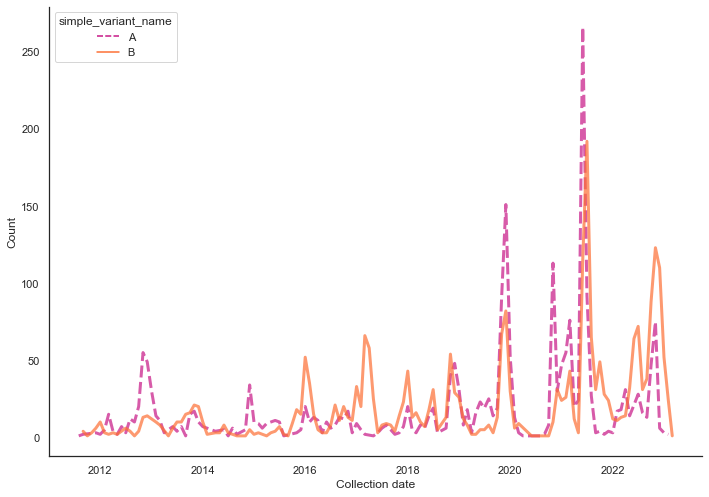

In [5]:
grouped_by_variant=rsv_df.groupby(["simple_variant_name","collection_month_year"]).sum().reset_index()

ax=graph_lineplot(df=grouped_by_variant, x="collection_month_year",y="ocurrence_counter",
             hue="simple_variant_name",style="simple_variant_name",order=["B","A"],
             pal=c_pal,linewidth=3,alpha=.7,linestyle="-")

In [6]:
md=pd.DataFrame(rsv_df.groupby(["collection_month_year"]).sum().reset_index())
month_year_dict=dict(zip(md["collection_month_year"],md["ocurrence_counter"]))


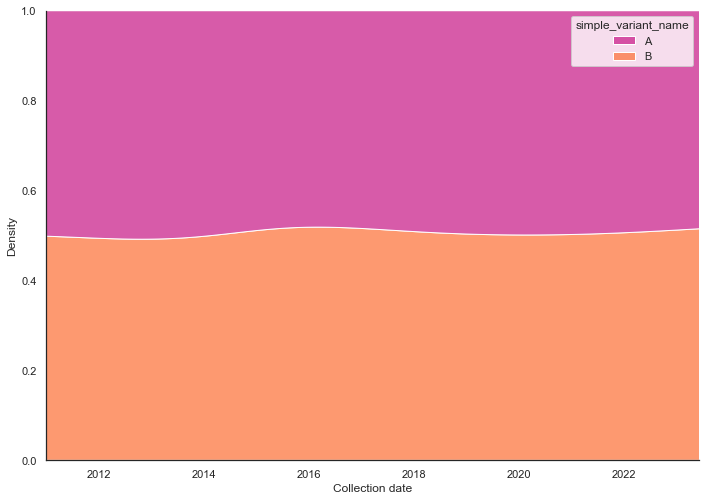

In [7]:

grouped_by_variant["frequency_counter"]=[item/month_year_dict[grouped_by_variant["collection_month_year"].iloc[i]]
                                         for i, item in enumerate(grouped_by_variant["ocurrence_counter"])]
end=datetime.strptime("06/06/23", '%m/%d/%y')
start=datetime.strptime("01/01/11", '%m/%d/%y')

ax=graph_kde(df=grouped_by_variant,x="collection_month_year",hue="simple_variant_name",pal=c_pal,
             start=start,end=end)

When examining raw-counts and frequencies, RSVB and RSVA seem to trade off on dominance depending on the year. Though dominance is used loosely here, as they are never more than 10% apart from one another

## Country of origin breakdown

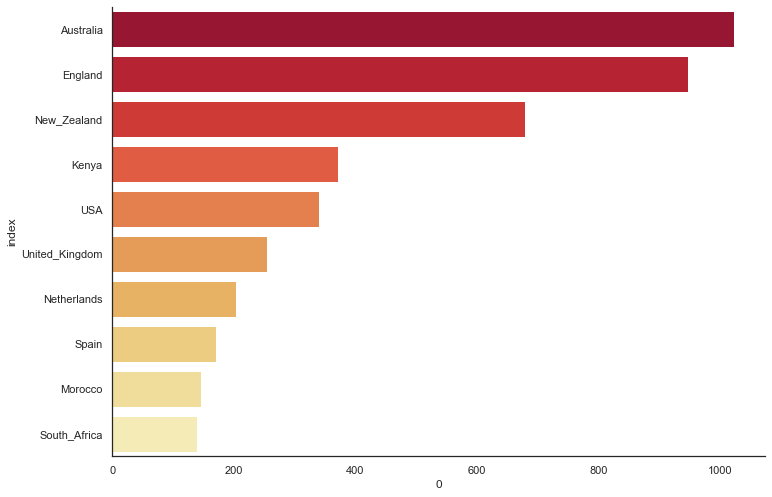

In [8]:
country_barplot=graph_barplot(rsv_by_country.iloc[0:10],y="index",x=0,pal=sns.color_palette('YlOrRd_r',n_colors=10))

I've limited the country count to the top 10, since the countries ranking 11+ have less than 100 submissions to GISAD over a 10+ year period. Since GISAID is an English website, it makes sense that 6/10 top submitters are from  English speaking countries.

# Collection date breakdown

What conditions make RSV more/less prevalent in certain years, if any?

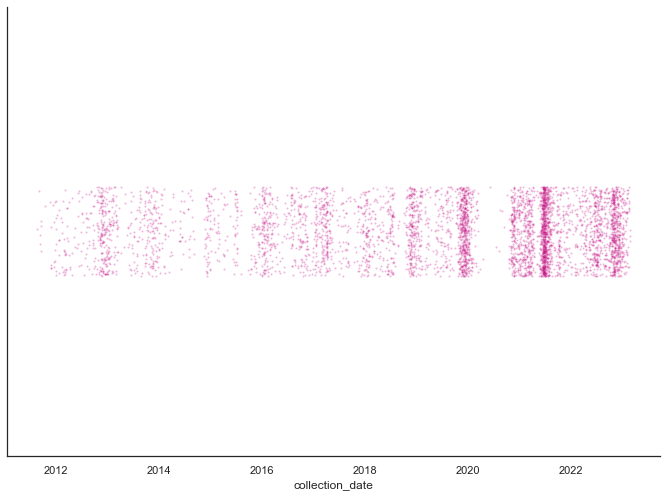

In [9]:
collection_date_swarmplot=graph_stripplot(rsv_df,"collection_date",c1)

With this stripplot, the seasonality of RSV is clearly visible. There are lower density areas spaced consistently year-by-year.

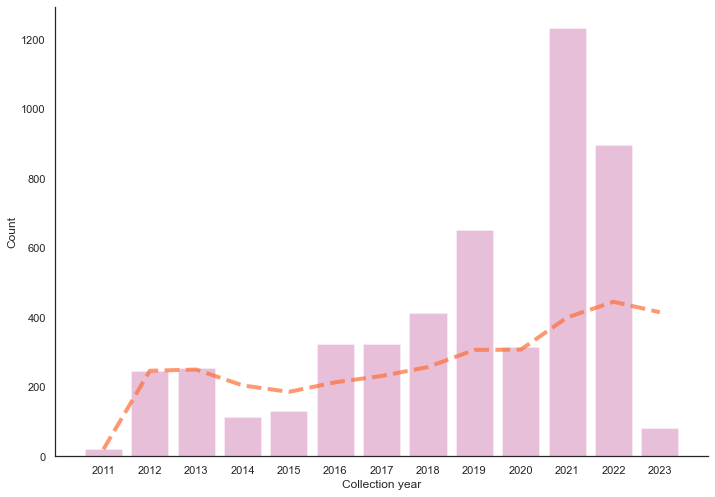

In [10]:
rsv_df["collection_year"]=[item[:item.index("-")] for item in rsv_df["collection_date"].astype(str)]
year_countplot=graph_countplot(df=rsv_df,x="collection_year",average_line=True,bar_color=c1,line_color=c2)

After the emergence of SARS-CoV2 in 2019, RSV greatly rose in submission count in 2021 and 2022. This data was pulled early April 2023 so it is too early to hypothesize on the trends this year.

# BLAST analysis
Now that we have done some EDA on the metadata of our sequences, lets examine the sequences themselves.

First we will make a database of all our BLAST sequences, using an RSVA sequence as our reference

##### %%bash
makeblastdb -in gisaid_rsv_2023_04_13_05.fasta -parse_seqids -dbtype nucl
#align database against RSVA reference
blastn -query RSVA_ref.fasta -db gisaid_rsv_2023_04_13_05.fasta -num_alignments 5000 -out test_results.txt

The BLAST alignment results contain a lot of unneeded information, so I'll use a few bash commands to extract the most relevant information.

In [9]:
%%bash
#extract out results, removing alignments
grep -E -v 'Query|Sbjct|    ' test_results.txt| grep . > short_results.txt
#remove summary table at start of results
start=$(grep -n ">" short_results.txt | head -n 1 | cut -d ":" -f1)
tail -n +$start short_results.txt > short_results_homology_only.txt


In [11]:
cloud_list=create_blast_cloud_from_homology_results("short_results_homology_only.txt",">")
hue_list=[item[find_nth(item, "/", 1)+1:find_nth(item, "/", 2)] for item in cloud_list.get_cloud_names()]

Lets see if there is a significant difference in length across our RSV genomes

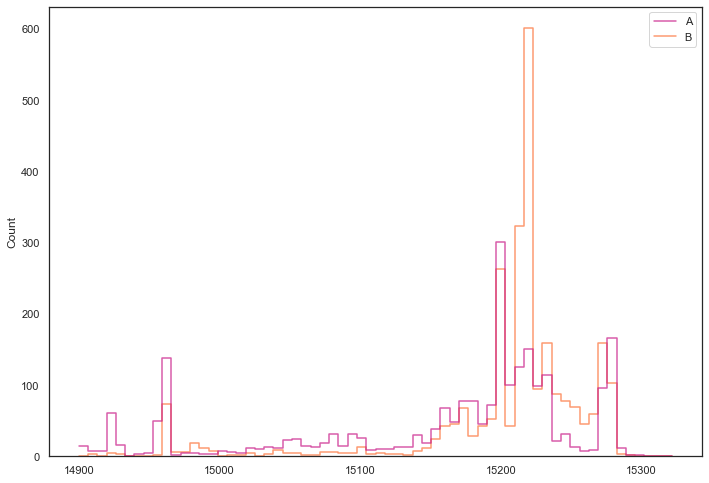

In [12]:
sns.histplot(x=cloud_list.get_cloud_lengths(),color=c1,alpha=0.7,
                hue=hue_list,
                palette=c_pal, element="step", fill=False)

The vast majority of sequences are 15,200 bp in length +/- 100 base pairs. However there is a small, but significant subset of genomes with a length between 14,900 and 15,000 base pairs. Most of these genomes are RSVA. 

Visually RSVB seems to have less variance in length vs RSVA. Lets verify this numerically

In [13]:
rsv_types_list=[[],[]]
ordering={"A":0,"B":1}

for i,item in enumerate(cloud_list.get_cloud_lengths()):
    rsv_types_list[ordering[hue_list[i]]].append(item)
    
print(" RSVA\n mean:", np.mean(rsv_types_list[0]), 
      "base pairs\n standard deviation",
      np.std(rsv_types_list[0]),"base pairs")
print(" RSVB\n mean:", np.mean(rsv_types_list[1]), 
      "base pairs\n standard deviation",
      np.std(rsv_types_list[1]),"base pairs")

 RSVA
 mean: 15158.969876962241 base pairs
 standard deviation 101.95735392826133 base pairs
 RSVB
 mean: 15204.06833712984 base pairs
 standard deviation 68.44070226401858 base pairs


The average RSVA genome length is indeeed lower than the average RSVB genome length and subject to much more standard deviation

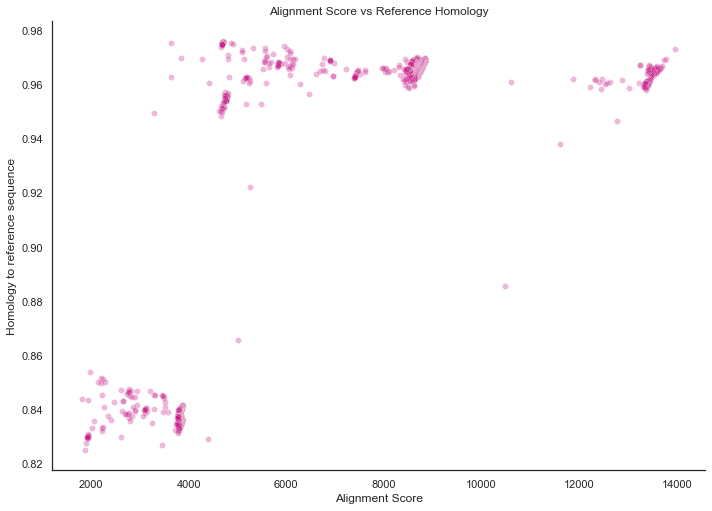

In [14]:
plt.gca().set(xlabel="Alignment Score",ylabel="Homology to reference sequence",title="Alignment Score vs Reference Homology")
ax=graph_scatterplot(df=None,x=cloud_list.get_cloud_scores(),y=cloud_list.get_cloud_homologies(),color=c1)


The fasta sequences are clustering into two seperate homology groups. Since we are using a RSV reference we can reasonably guess that the RSVB reference/sequences would lie in this lower homology cluster. This can be easily confirmed with another alignment.

In [11]:
!blastn -subject RSVA_ref.fasta -query RSVB_ref.fasta -evalue 100 -num_alignments 5000 -out referece_aln.txt

In [12]:
%%bash
#extract out results, removing alignments
grep -E -v 'Query|Sbjct|    ' referece_aln.txt| grep . > short_reference_aln.txt
#remove summary table at start of results
start=$(grep -n ">" short_results.txt | head -n 1 | cut -d ":" -f1)
tail -n +$start short_reference_aln.txt > short_reference_aln_homology_only.txt


In [15]:
ref_cloud_df=create_blast_cloud_from_homology_results("short_referece_aln_homology_only.txt",
                                                    "Strand",one_node=True).get_cloud_df()
cloud_df=cloud_list.get_cloud_df()
all_df=pd.concat([cloud_df,ref_cloud_df])

hue=cloud_list.get_cloud_names_simple()+["C"]
color_list=[c1,c2,"grey"]
size_list=[0.1]*(len(all_df)-1)+[5]


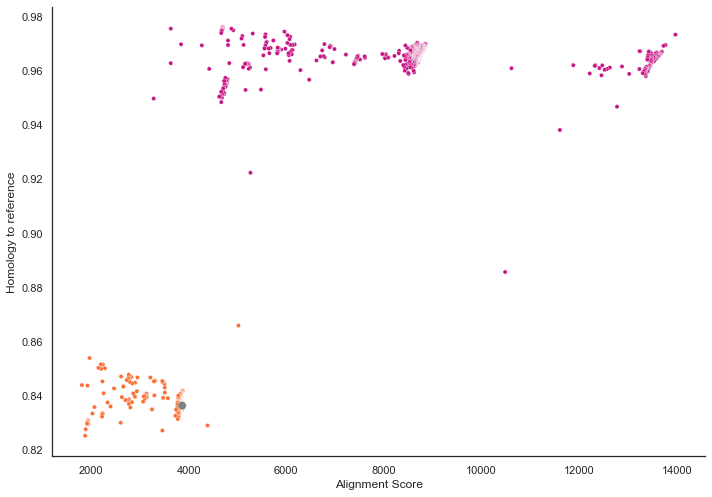

In [16]:
plt.gca().set(xlabel="Alignment Score",ylabel="Homology to reference")
ax=graph_scatterplot(df=all_df,x="score",y="homology",pal=color_list,alpha=1,
                     hue=hue,size=size_list)


The RSVB reference does appear in the bottom left cluster, as predicted

RSVA and RSVB appear to be classifiable with these two features. Let us verify RSVA and RSVB are classifiable by their features, and if yes which features are the most valuable in said classification process.
### Classification validity

In [17]:
X=cloud_df.drop("name",axis=1)
y=cloud_df["name"].replace("A",0).replace("B",1)
#controlling random state makes results reproducable
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=32)

In our data we will use binary classification with the following parameters:
- RSV**A**=0
- RSV**B**=1

Now we will determine the validity of our training and test split

In [18]:
print("Training data split\n",y_train.value_counts(normalize=True))
print("\nTest data split\n",y_test.value_counts(normalize=True))


Training data split
 1    0.527555
0    0.472445
Name: name, dtype: float64

Test data split
 1    0.528529
0    0.471471
Name: name, dtype: float64


The training and test data have the same ratios of rsva to rsvb

### Optimizing our parameters with grid search 

Grid search creates optimal input parameters for our classification algorithms
#### Random forest

In [19]:
random_forest_params = {'max_features':['sqrt', 'log2'], 'criterion': ['gini', 'entropy']}

random_forest_feats,random_forest_critereon=grid_search(RandomForestClassifier(n_estimators=1000),
                                                       random_forest_params,X_train,y_train)
random_forest = RandomForestClassifier(max_features=random_forest_feats,criterion=random_forest_critereon)

print("We will be using", random_forest_feats, "feature maximalization and", 
      random_forest_critereon, " critereon with random forest")


We will be using sqrt feature maximalization and gini  critereon with random forest


#### K Nearest Neighbor

In [20]:
k_nn_neighbors=grid_search(KNeighborsClassifier(),
                                      {'n_neighbors': np.arange(1, 10)},
                                      X_train,y_train)

k_nn = KNeighborsClassifier(n_neighbors = k_nn_neighbors[0])
print("We will have", k_nn_neighbors[0], "neighbors with KNN")

We will have 3 neighbors with KNN


#### Linear Discriminant Analysis

In [21]:

warnings.filterwarnings('ignore')
lda_solver=grid_search(LinearDiscriminantAnalysis(),
                                      {'solver':['svd', 'lsqr', 'eigen']},
                                      X_train,y_train)

LDA = LinearDiscriminantAnalysis(solver = lda_solver[0])

print("We will use the", lda_solver[0], "solver with LDA")


We will use the svd solver with LDA


Now that our input parameters have been optimized, we can actually run our classifiers on our test data

In [22]:
res=[]
for clf in [LDA,k_nn,random_forest]:
    name=clf.__class__.__name__
    results=calculate_scores(clf,X_train, y_train,X_test,y_test)
    res.append(calculate_scores(clf,X_train, y_train,X_test,y_test))
classification_res=pd.DataFrame(res,columns=["Name",'Accuracy','Precision','Recall','Fscore'])


In [23]:
classification_res

,Name,Accuracy,Precision,Recall,Fscore
0,LinearDiscriminantAnalysis,99.70%,99.70%,99.69%,99.70%
1,KNeighborsClassifier,99.60%,99.61%,99.59%,99.60%
2,RandomForestClassifier,99.70%,99.70%,99.69%,99.70%


All classifiers performed extremely similarly with RandomForest and LDA slighly outperforming KNN. This difference is not large enough to be significant.


As we suspected it is possible to classify RSVA and RSVB sequence easily with the data at hand. Now we can test if all of our features have equal weight in the classification process with some regression. 

### Linear Regression to determine feature weights
Since Random Forest was one of our top classifiers, I will use it as our regression model carrying over our grid search parameters when possible

In [29]:
random_forest_regression = RandomForestRegressor(max_features='sqrt')
# fit the model
names=X.columns
score=[]
random_forest_regression.fit(X, y)
# get importance
feature_importance = random_forest_regression.feature_importances_
# summarize feature importance
for i,v in enumerate(feature_importance):
    score.append(v)

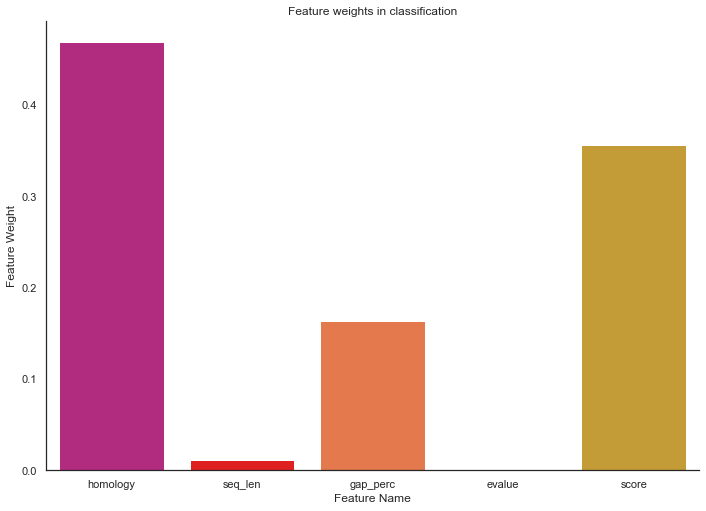

In [30]:
plt.gca().set(title="Feature weights in classification",xlabel="Feature Name",ylabel="Feature Weight")
ax=graph_barplot(df=None,y=score,x=names,pal=[c1,"red",c2,"0","goldenrod"])


Unsuprisingly, homology is the most important feature. Score and alignment gaps (gap_perc) are closely related to homology so their high ranking is also unsuprising. Sequence length and E-value are largely unimportant